<a href="https://colab.research.google.com/github/RgomezRo/capstone/blob/main/Modelo%20Seleccionado%20%3A%20Modelo%20final%20con%20cluster%20por%20producci%C3%B3n(6%20cl%C3%BAsters).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [501]:
AUTORUNTHISWONDERFULLPROGRAM = True

In [502]:
pip install squarify

In [503]:
!pip install wget

In [504]:
!pip install calmap

In [505]:
#@title imports

### importamos librerías

'''
instalar:
- plotly
- calmap
- folium
- wget
'''

#analisis
import pandas as pd 
import numpy as np
import sys
from scipy.stats import kurtosis, skew 
from scipy import stats
from google.colab import output
import datetime as dt

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)

#visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import calmap
import folium

#paletas
confirmados='#393e46'
fallecidos='#ff2e63'

import wget
import os
import json

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading

In [506]:
#@title Funcion de lectura de data sets read_FAO()
import requests 
import os 
def read_FAO(fileName):
	
	Database = fileName + ".csv"

	if(os.path.isfile(Database)!=True):

		file_url = "https://fenixservices.fao.org/faostat/static/bulkdownloads/"+fileName+".zip"
			
		r = requests.get(file_url, stream = True) 

		with open("temporalFile.zip", "wb") as file: 
			for block in r.iter_content(chunk_size = 1024): 
				if block: 
					file.write(block) 
			
		!unzip temporalFile.zip 

			
	df = pd.read_csv(Database, encoding = "ISO-8859-1")

	return df




In [507]:
#@title Lectura de datos

### leer origenes

df_food_balances = read_FAO("FoodBalanceSheets_E_All_Data_(Normalized)")

df_emissions = read_FAO("Emissions_Totals_E_All_Data_(Normalized)")

df_emissions_share = read_FAO("Environment_Emissions_by_Sector_E_All_Data_(Normalized)")

df_food_transport = read_FAO("Environment_Transport_E_All_Data_(Normalized)")

df_waste_disposal = read_FAO("Emissions_Agriculture_Waste_Disposal_E_All_Data_(Normalized)")

#### leer cluster de Pere
### modelo x sector
path_kmeans_sector = "/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/Cluster_Paises.csv"
### modelo x producción de alimentos y usos
path_kmeans_prod = "/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/Modelos kmeans/Cluster_Paises_Produccion_Imp_Exp_4_clusters (1).csv"
### modelo x emisiones x proceso 4 clusters
path_kmeans_emiss = "/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/Modelos kmeans/Cluster_Paises_Emis_Totales.csv"
### modelo x emisiones x proceso 6 clusters

path_kmeans_emiss_6 = "/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/Modelos kmeans/Cluster_Paises_Emis_Totales_6_clusters.csv"

df_cluster_paises = pd.read_csv(path_kmeans_emiss_6, encoding = "ISO-8859-1")

### Filters and transformations 

df_food_balances["Year"] = pd.to_datetime(df_food_balances.Year, format='%Y')
df_emissions["Year"] = pd.to_datetime(df_emissions.Year, format='%Y')
df_emissions_share["Year"] = pd.to_datetime(df_emissions.Year, format='%Y')
df_food_transport["Year"] = pd.to_datetime(df_food_transport.Year, format='%Y')
df_waste_disposal["Year"] = pd.to_datetime(df_waste_disposal.Year, format='%Y')

#filtramos por los países del cluster de pere
df_food_balances = df_food_balances [df_food_balances["Area"].isin(df_cluster_paises["Area"].unique())]
df_emissions = df_emissions [df_emissions["Area"].isin(df_cluster_paises["Area"].unique())]
df_emissions_share=df_emissions_share[df_emissions_share["Area"].isin(df_cluster_paises["Area"].unique())] 
df_food_transport =df_food_transport[df_food_transport["Area"].isin(df_cluster_paises["Area"].unique())]
df_waste_disposal =df_waste_disposal[df_waste_disposal["Area"].isin(df_cluster_paises["Area"].unique())]




In [508]:
df_cluster_paises.head()

,Unnamed: 0,Area,cluster
0,0,Afghanistan,0
1,1,Albania,4
2,2,Algeria,0
3,4,Andorra,0
4,5,Angola,0


In [509]:
#@title one hot encoding para K-Means cluster
def transform_cluster_to_one_hot(df_cluster,cluster_field="cluster"):
  cluster_data = pd.get_dummies(df_cluster[cluster_field], prefix='Cluster')
  df_to_return = df_cluster.join(cluster_data).reset_index()

  to_ret =[]
  for column in cluster_data.columns:
    to_ret.append(column)
  to_ret.append("Area")
  df_to_return= df_to_return[to_ret]
  return df_to_return

df_cluster_paises= transform_cluster_to_one_hot(df_cluster_paises,)

  
df_cluster_paises.head(2)

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Area
0,1,0,0,0,0,0,Afghanistan
1,0,0,0,0,1,0,Albania


# Data filtering



In [510]:
#@title Function to show nulls and gaps in data : show_gaps_data { display-mode: "form" }
def show_gaps_data(df_input,title ="Nulos en el dataset"):
  # create a smaller df

  df_input["MeasuredItem"]= df_input["Item"] + "-"+ df_input["Element"]

  # in order to show and fill na we aggregate a little bit the info

  short_df = df_input[["Year", "Value","MeasuredItem"]]


  # show  gaps in the data

  gb_df_ = short_df.pivot_table(index = ["Year"], columns = ['MeasuredItem'], values = "Value", aggfunc = sum).isnull()
  #gb_df_= gb_df_.fillna(0)

  order_of_columns = list(gb_df_.sum().sort_values().index)
  
  gb_df_ = gb_df_[order_of_columns]


  plt.figure(figsize = (20, 10))
  plot = sns.heatmap(gb_df_, cbar = True, cmap = "inferno")
  plot.set_title(title);

  
  







In [511]:
#@title Function to create tree map : plot_tree_map()

#libraries
import matplotlib.pyplot as plt
import squarify # pip install squarify (algorithm for treemap)

def plot_tree_map(input_df, column_label, column_value,graph_title, string_to_repleace="Dummie", percentage_of_record_not_showed = 2):
  # Change color
  # squarify.plot(sizes=[13,22,35,5], label=["group A", "group B", "group C", "group D"], color=["red","green","blue", "grey"], alpha=.4 )
  # plt.axis('off')
  # plt.show()
  # values and labels
  # values and labels
  function_df =input_df.groupby(column_label).sum().reset_index()
  function_df[column_label] = function_df[column_label].str.replace(string_to_repleace, '', regex=False)
  function_df = function_df[function_df[column_value]> function_df[column_value].sum()*(percentage_of_record_not_showed/100)]
  function_df.reset_index()
  my_values = function_df[column_value]
  my_pct = function_df[column_value]/function_df[column_value].sum()
  labels = ['{} \n {:.2f}%'.format(column_label , pct*100) for column_label , pct in zip(function_df[column_label], my_pct)]

  #plot
  plt.figure(figsize = (34, 10))
  squarify.plot(sizes = my_values, label = labels,edgecolor="white", linewidth=2,  alpha = 0.5, text_kwargs={'fontsize':18,'color':"black"})
  plt.title(" \n"+ graph_title+" \n",fontsize = 23, fontweight = "bold")


In [512]:
#@title Data description function DataDesc
def DataDesc(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
    
    return summary

In [513]:
#@title Function for null nnalysis : Null_Count()

def Null_Count(df):
    df_null = df.isnull().sum().sort_values(ascending = False).rename('Null').reset_index()

    null_count = df_null['Null']
    null_percent = (null_count * 100) / (df.shape[0])

    df_null = pd.concat([df_null['index'],null_count,null_percent], axis=1, keys=['Column','Null_Count','Null_Percent'])

    return df_null[df_null['Null_Count'] != 0]





## Emissions data

Los datos de emisiones, como veremos a continuación contienen multitud de información.



Además de venir separados en **dos datasets distintos**, la información contienen **agrupaciones** por distintas metodologías todas ellas relacionadas con la **cadena de producción**:
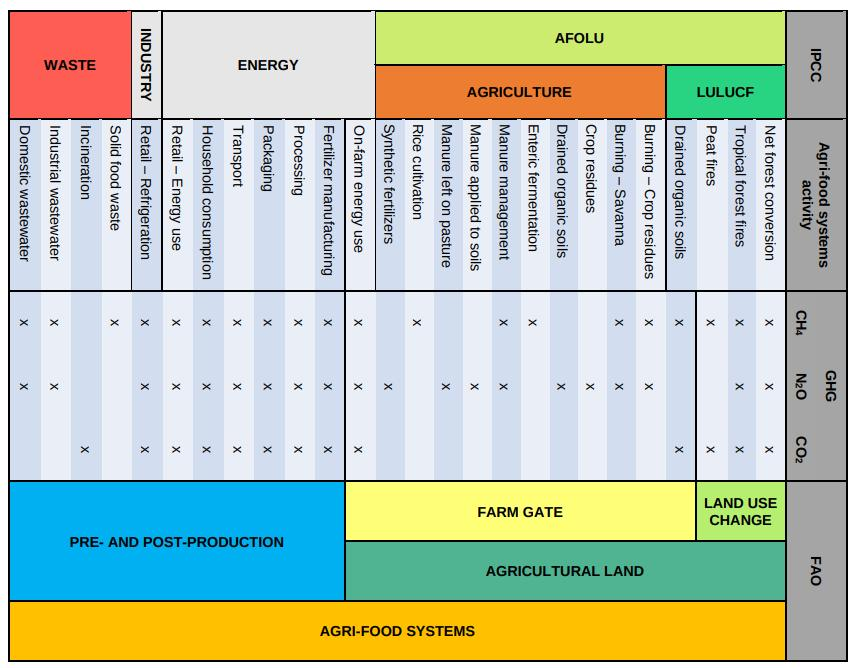

Por otro lado disponemos de **distintos tipos de emisiones**.


Para nuestro objetivo, cuánto vale lo que comemos , solo nos interesa aquellos que influyan en la huella de carbono, por lo tanto nos fijaremos en los datos de **carbono equivalente**

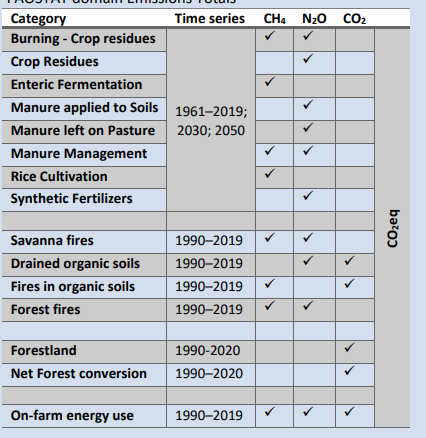



**Explicación data set "Emission Shares" AKA df_emission_share**



> The FAOSTAT Emissions shares domain disseminates data on absolute levels of greenhouse
gas (GHG) emissions and their shares in the GHG total by all sectors.

> Data are provided by
country and relevant regional groups, over the period 1990-2019, by economic sector and
agri-food system component.

> Emissions and their shares are provided in CO2 equivalent
(CO2eq), carbon dioxide (CO2), methane (CH4), nitrous oxide (N2O) and of the aggregate
fluorinated gases (F-gases).

> Emissions estimates are grouped in activities from farm gate,
land use change and pre- and post-production processes.


> *   The activity data and the emissions
and removals from agriculture, forestry and other land use (AFOLU), as well as those
relevant to farm gate and land use change processes, are taken from FAO (2021).
*   Emissions
from pre- and post-production processes are calculated by FAO based on UNSD, IEA and
other third-party activity data, as well as by integrating emission information from the
PRIMAP-hist dataset v2.3 (Gütschow et al., 2021).

**Explicación data set "Emissions" AKA df_emission**


> The FAOSTAT domain Emissions Totals summarizes the greenhouse gas (GHG) emissions disseminated in the FAOSTAT Climate Change Emissions domains, generated from agriculture and forest land.

> They consist of methane (CH4), nitrous oxide (N2O) and carbon dioxide (CO2) emissions from crop and livestock activities, forest management and include land use and land use change processes. 





 

A modo de curiosidad, aunque no vaya con nuestro proyecto, estas son los **distintos tipos de emisiones** presentes en el data set

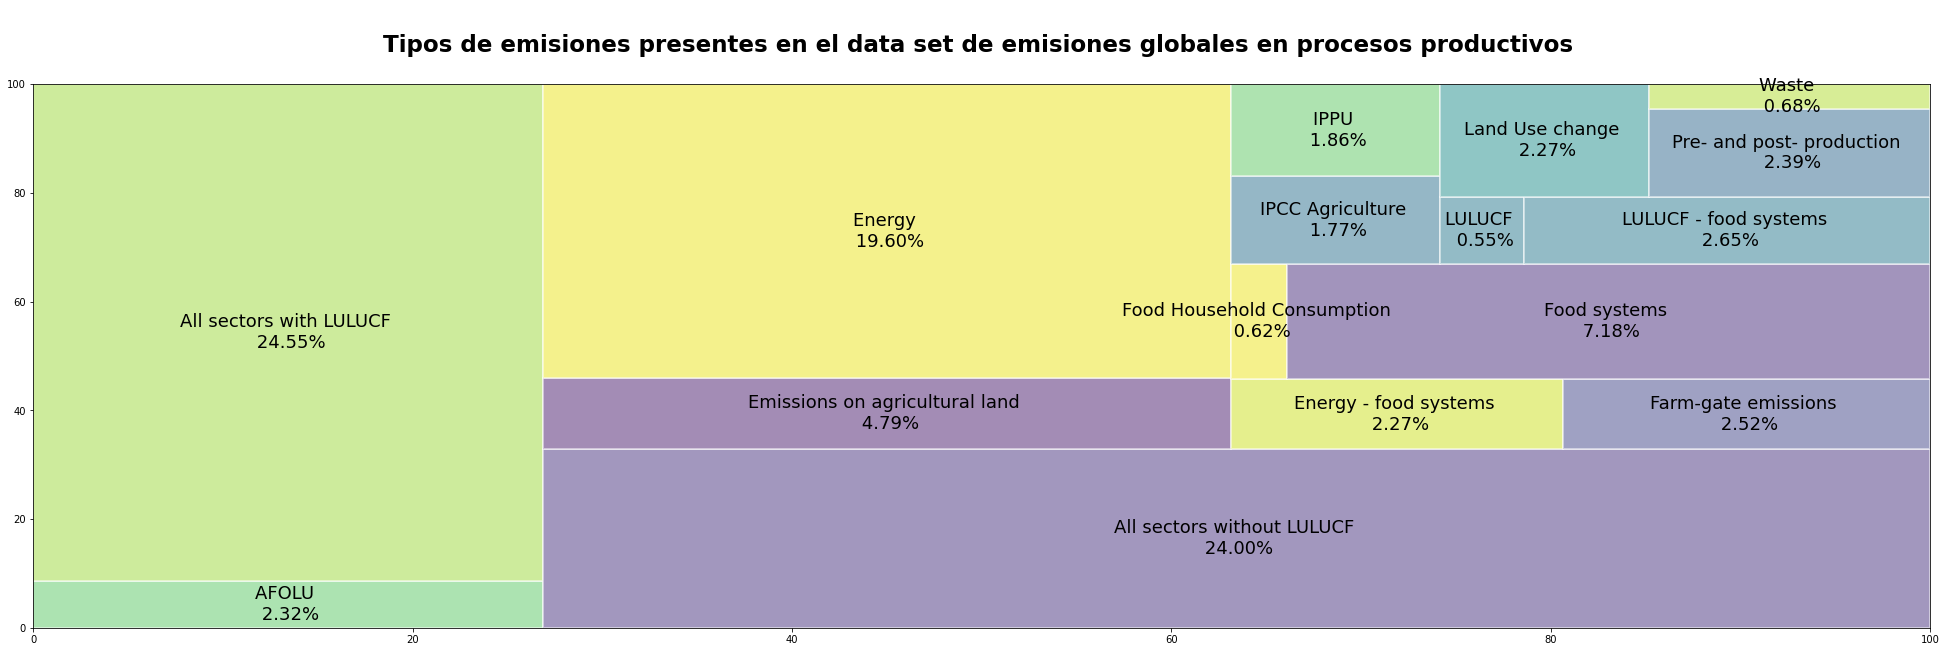

In [514]:
plot_tree_map(df_emissions_share, "Item", "Value","Tipos de emisiones presentes en el data set de emisiones globales en procesos productivos",percentage_of_record_not_showed=0.5)

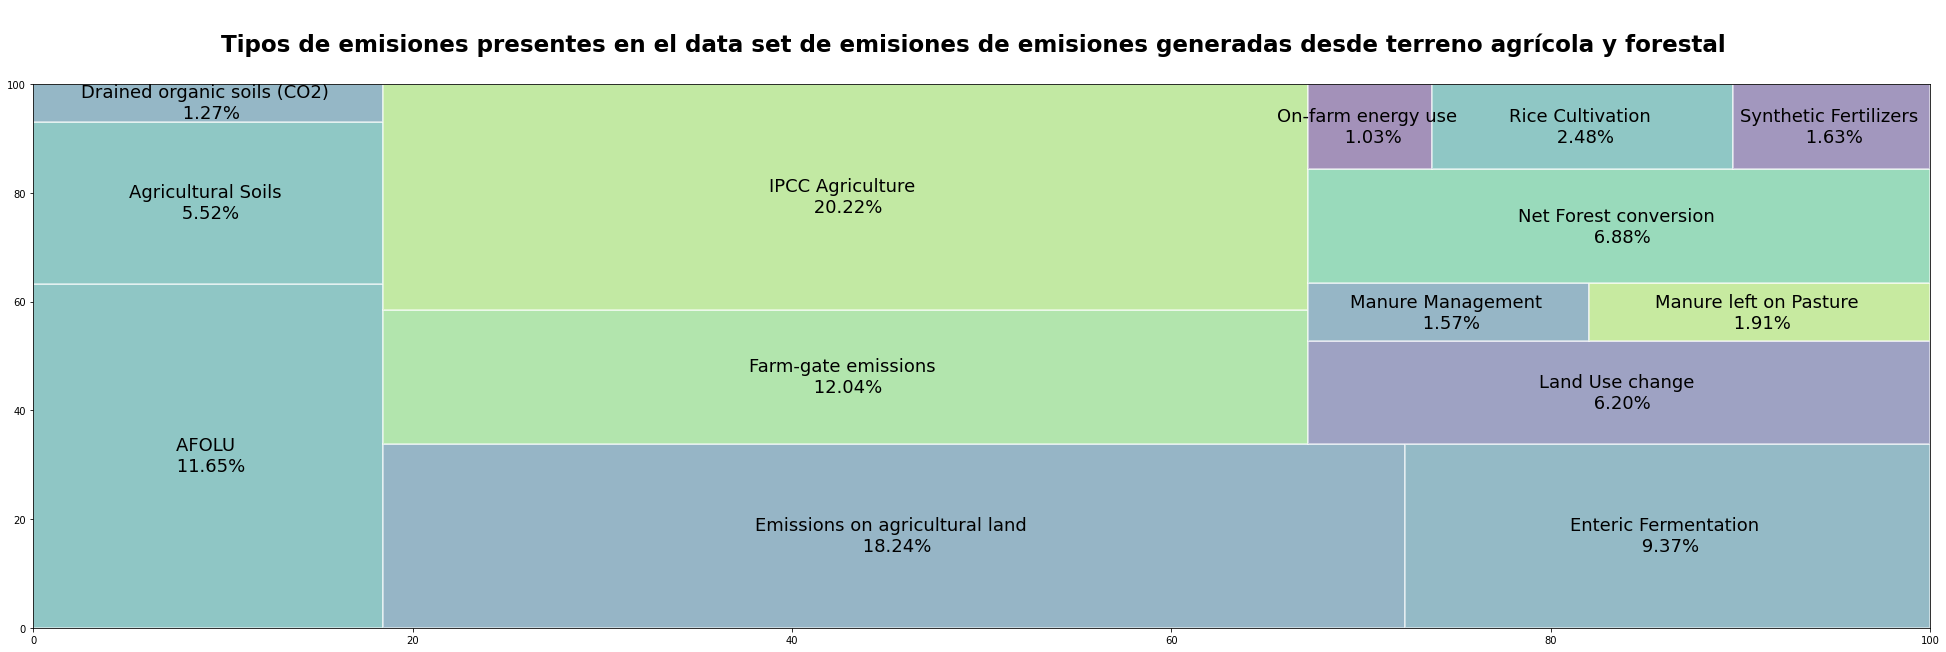

In [515]:
plot_tree_map(df_emissions, "Item", "Value","Tipos de emisiones presentes en el data set de emisiones de emisiones generadas desde terreno agrícola y forestal ",percentage_of_record_not_showed=1)

In [516]:
display(df_emissions["Element"].unique())
display(df_emissions_share["Element"].unique())
display(df_emissions["Item"].unique())
display(df_emissions_share["Item"].unique())

array(['Emissions (CH4)', 'Emissions (CO2eq) from CH4 (AR5)',
       'Emissions (CO2eq) (AR5)', 'Emissions (N2O)',
       'Emissions (CO2eq) from N2O (AR5)', 'Direct emissions (N2O)',
       'Indirect emissions (N2O)', 'Emissions (CO2)'], dtype=object)

array(['Emissions Share (CO2eq) (AR5)', 'Emissions Share (CO2)',
       'Emissions Share (CH4)', 'Emissions Share (N2O)',
       'Emissions (CO2eq) (AR5)', 'Emissions (CO2)', 'Emissions (CH4)',
       'Emissions (N2O)', 'Emissions (F-gases)',
       'Emissions Share (F-gases)'], dtype=object)

array(['Enteric Fermentation', 'Manure Management', 'Rice Cultivation',
       'Synthetic Fertilizers', 'Manure applied to Soils',
       'Manure left on Pasture', 'Crop Residues',
       'Burning - Crop residues', 'Net Forest conversion', 'Forestland',
       'Savanna fires', 'Fires in humid tropical forests', 'Forest fires',
       'Fires in organic soils', 'On-farm energy use', 'IPCC Agriculture',
       'Agricultural Soils', 'LULUCF', 'AFOLU',
       'Emissions on agricultural land', 'Farm-gate emissions',
       'Land Use change', 'Drained organic soils',
       'Drained organic soils (CO2)', 'Drained organic soils (N2O)'],
      dtype=object)

array(['Farm-gate emissions', 'Land Use change',
       'Pre- and post- production', 'Fertilizers Manufacturing',
       'IPCC Agriculture', 'LULUCF', 'On-farm electricity use',
       'LULUCF - food systems', 'Energy', 'Food Processing',
       'Energy - food systems', 'Food Transport', 'IPPU', 'Food Retail',
       'Food Waste Disposal', 'Waste', 'Waste - food systems',
       'Food Household Consumption', 'Food Packaging',
       'All sectors with LULUCF', 'All sectors without LULUCF', 'Other',
       'Food systems', 'AFOLU', 'Emissions on agricultural land',
       'IPPU - food systems'], dtype=object)

In [517]:
#@title Eliminación de agregados en el data set
## Filtrar datos no agregados (https://www.fao.org/faostat/en/#data/EM)
agro_measures_to_preserve = ["Burning - Crop residues","Crop Residues","Drained organic soils","Enteric Fermentation","Fires in organic soils","Forest fires","Forestland","Manure Management","Manure applied to Soils","Manure left on Pasture","Net Forest conversion","On-farm energy use","Rice Cultivation","Savanna fires","Synthetic Fertilizers" ]
share_measures_to_preserve = ["Fertilizers Manufacturing","Food Household Consumption","Food Packaging","Food Processing","Food Retail","Food Transport","Food Transport - International Bunkers","Food Waste Disposal","On-farm electricity use"]

## Filtrar datos de solo CO2eq
df_emissions = df_emissions[df_emissions["Element"]=="Emissions (CO2eq) (AR5)"]
df_emissions_share = df_emissions_share[df_emissions_share["Element"]=="Emissions (CO2eq) (AR5)"]

## Deshacerse de los agrupados
df_emissions = df_emissions[df_emissions["Item"].isin(agro_measures_to_preserve)]
df_emissions_share = df_emissions_share[df_emissions_share["Item"].isin(share_measures_to_preserve)]

## index reset
df_emissions = df_emissions.reset_index(drop=True)
df_emissions_share = df_emissions_share.reset_index(drop=True)



Volvemos a montar los gráficos, esta vez sin agregados

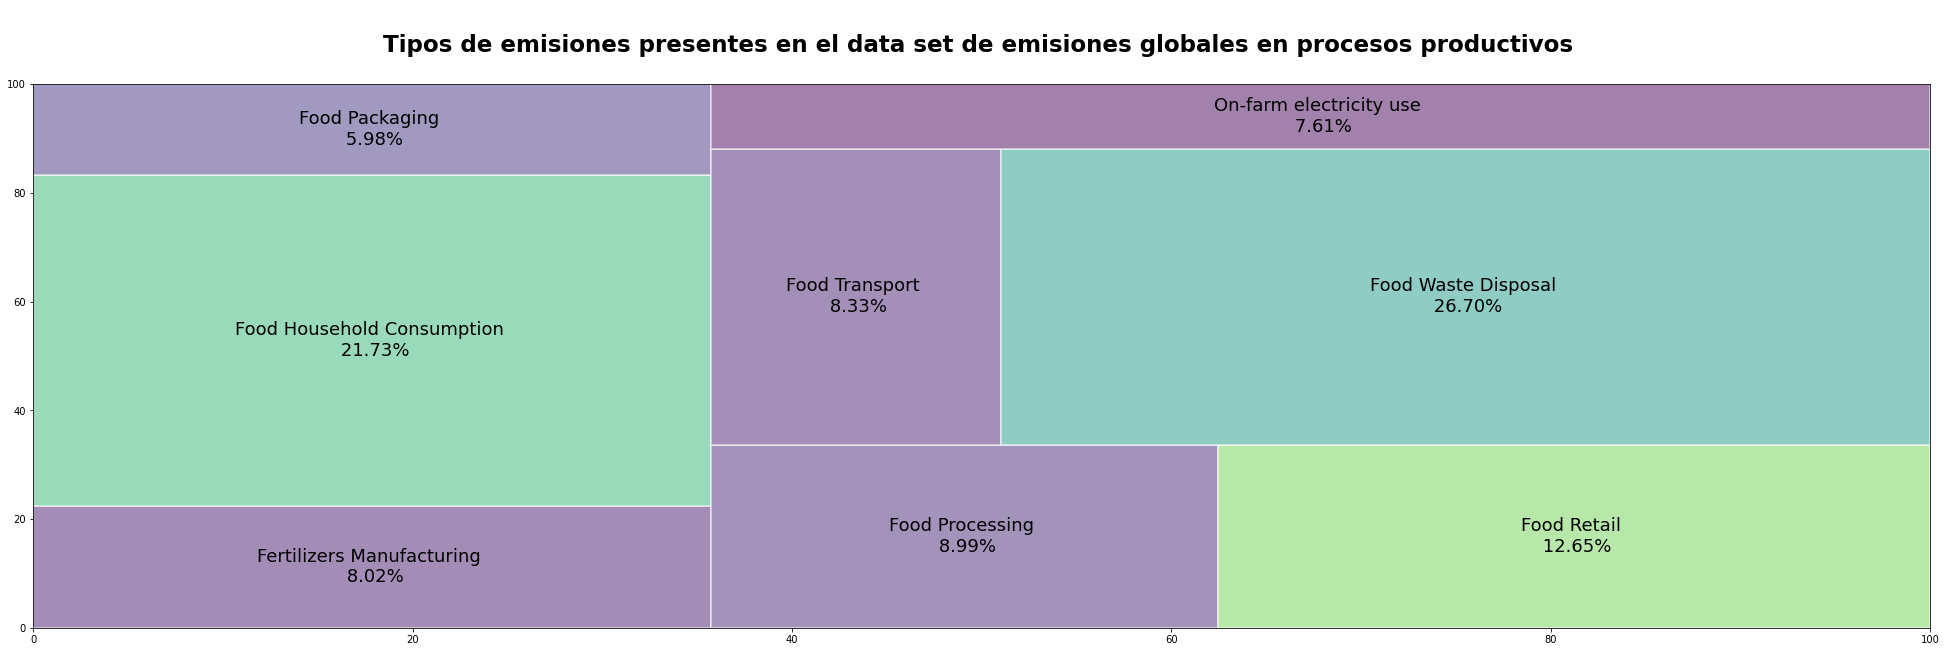

In [518]:
plot_tree_map(df_emissions_share, "Item", "Value","Tipos de emisiones presentes en el data set de emisiones globales en procesos productivos",percentage_of_record_not_showed=0.5)

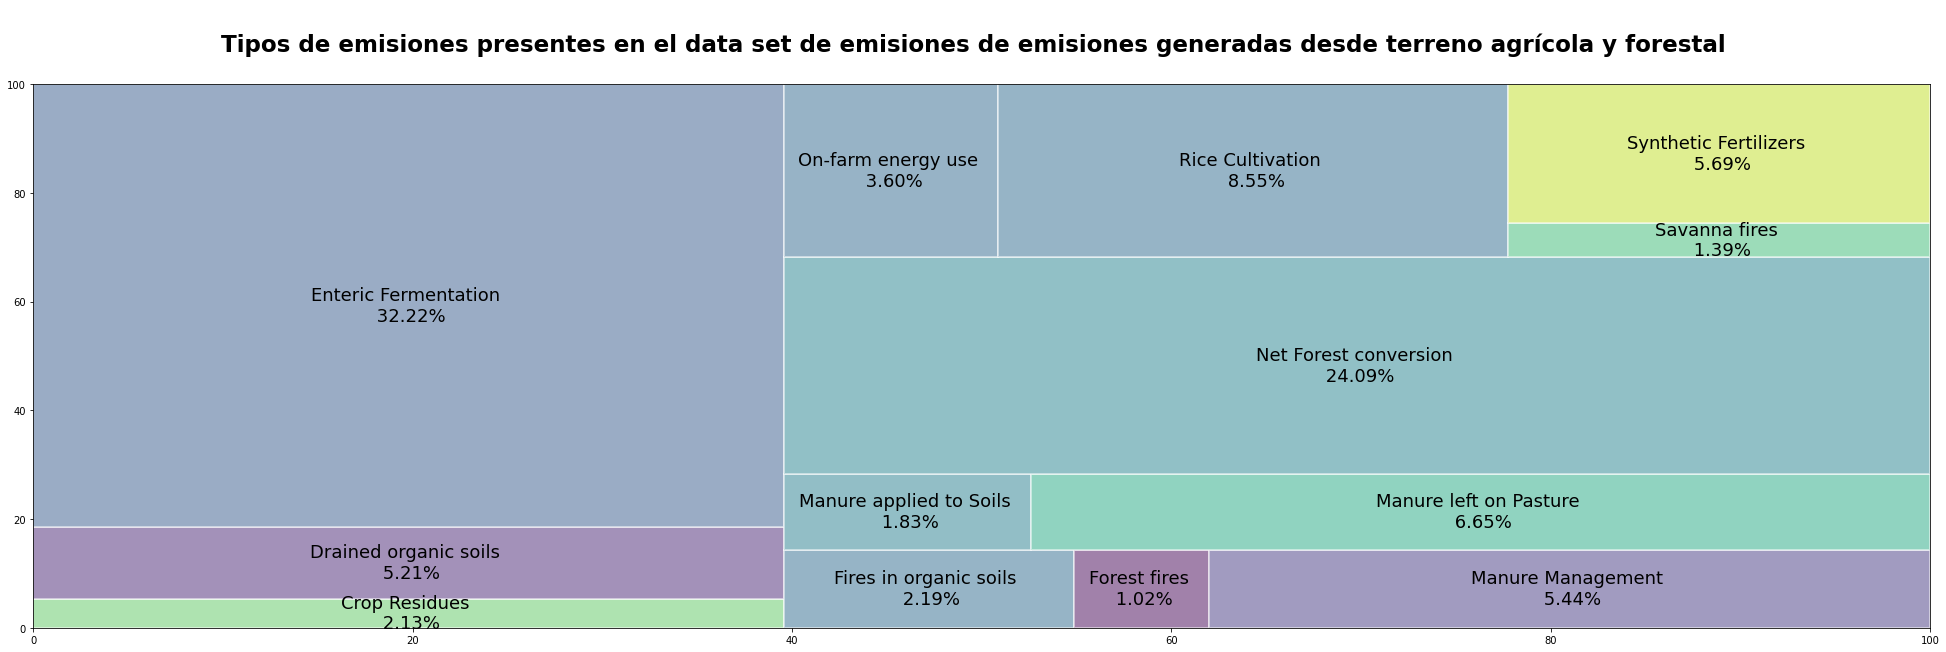

In [519]:
plot_tree_map(df_emissions, "Item", "Value","Tipos de emisiones presentes en el data set de emisiones de emisiones generadas desde terreno agrícola y forestal ",percentage_of_record_not_showed=1)

In [520]:
display(df_emissions["Element"].unique())
display(df_emissions_share["Element"].unique())
display(df_emissions["Item"].unique())
display(df_emissions_share["Item"].unique())

array(['Emissions (CO2eq) (AR5)'], dtype=object)

array(['Emissions (CO2eq) (AR5)'], dtype=object)

array(['Enteric Fermentation', 'Manure Management', 'Rice Cultivation',
       'Synthetic Fertilizers', 'Manure applied to Soils',
       'Manure left on Pasture', 'Crop Residues',
       'Burning - Crop residues', 'Net Forest conversion', 'Forestland',
       'Savanna fires', 'Forest fires', 'Fires in organic soils',
       'On-farm energy use', 'Drained organic soils'], dtype=object)

array(['Fertilizers Manufacturing', 'On-farm electricity use',
       'Food Processing', 'Food Transport', 'Food Retail',
       'Food Waste Disposal', 'Food Household Consumption',
       'Food Packaging'], dtype=object)

## Food Balances sheet
Este data set contiene información de mucho tipo acerca de cada país.
De momento dejamos dicha información disponible para su uso futuro.


In [521]:
df_food_balances.groupby(["Element","Unit"]).count().reset_index()[["Element","Unit"]]

,Element,Unit
0,Domestic supply quantity,1000 tonnes
1,Export Quantity,1000 tonnes
2,Fat supply quantity (g/capita/day),g/capita/day
3,Feed,1000 tonnes
4,Food,1000 tonnes
5,Food supply (kcal/capita/day),kcal/capita/day
6,Food supply quantity (kg/capita/yr),kg
7,Import Quantity,1000 tonnes
8,Losses,1000 tonnes
9,Other uses (non-food),1000 tonnes


Lo que si que podemos ir viendo ya la información de alimentos que usaremos para nuestro modelo y como se reparten en la dieta mundial

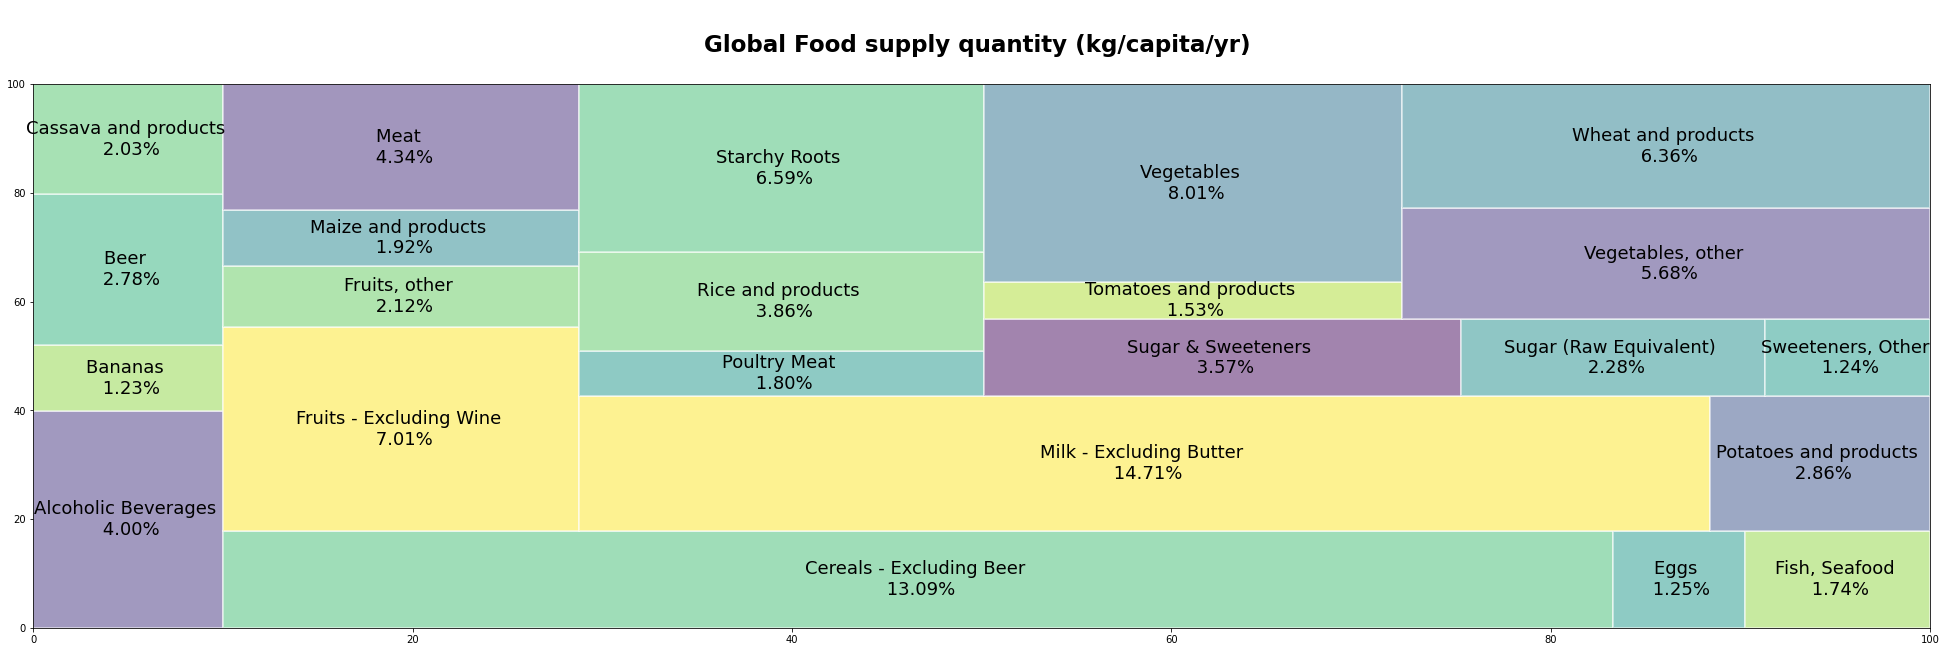

In [522]:
plot_tree_map(df_food_balances[df_food_balances["Element"]=="Food supply quantity (kg/capita/yr)"], "Item", "Value","Global Food supply quantity (kg/capita/yr)",percentage_of_record_not_showed=1)

# Análisis de los atributos y su cumplimentación (nulos)

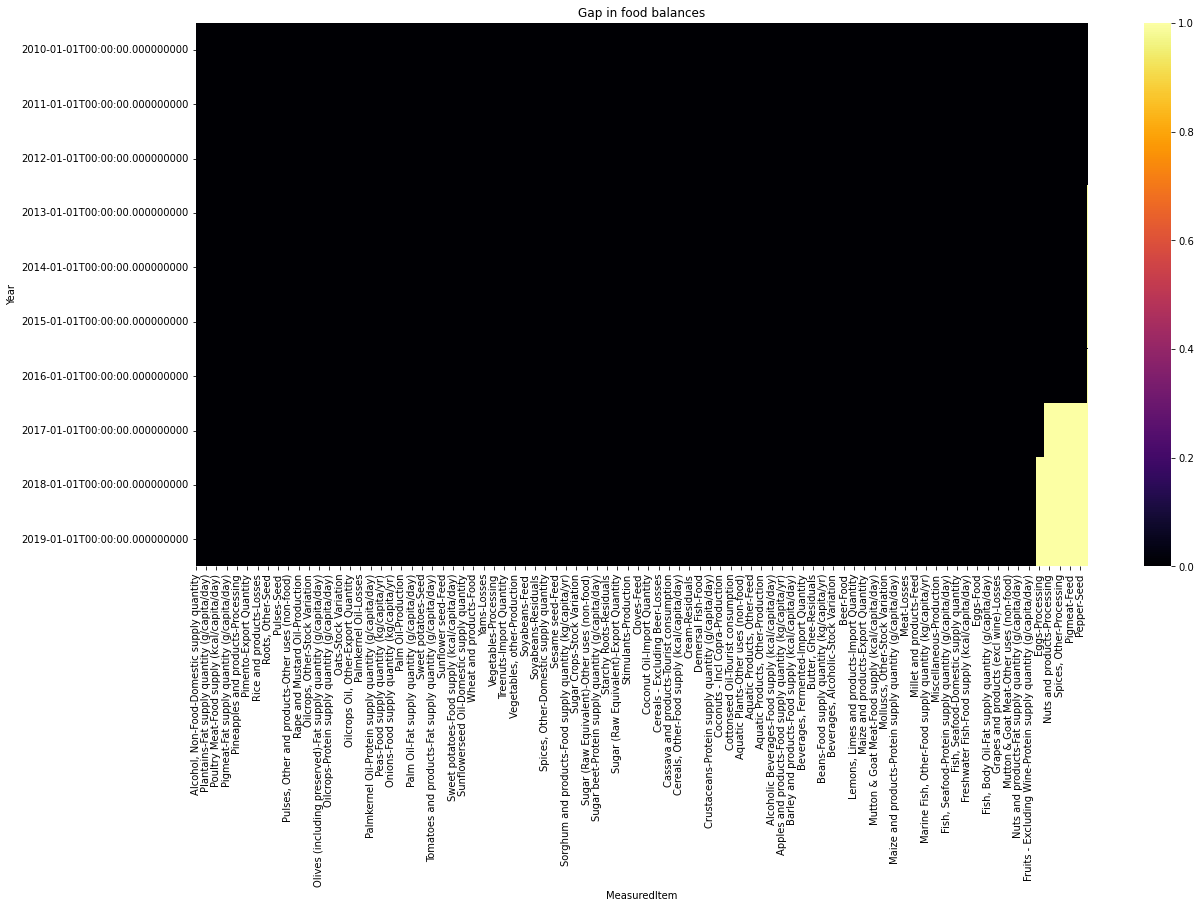

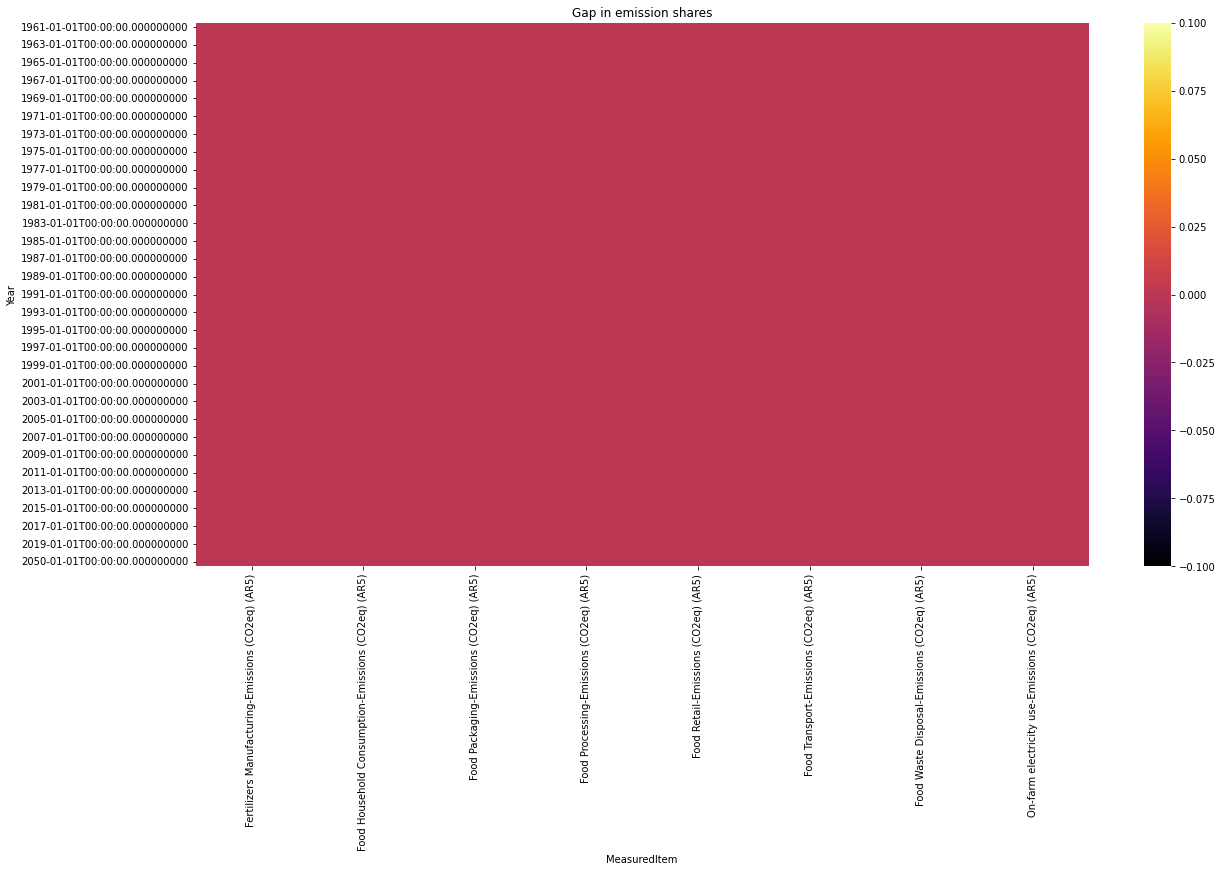

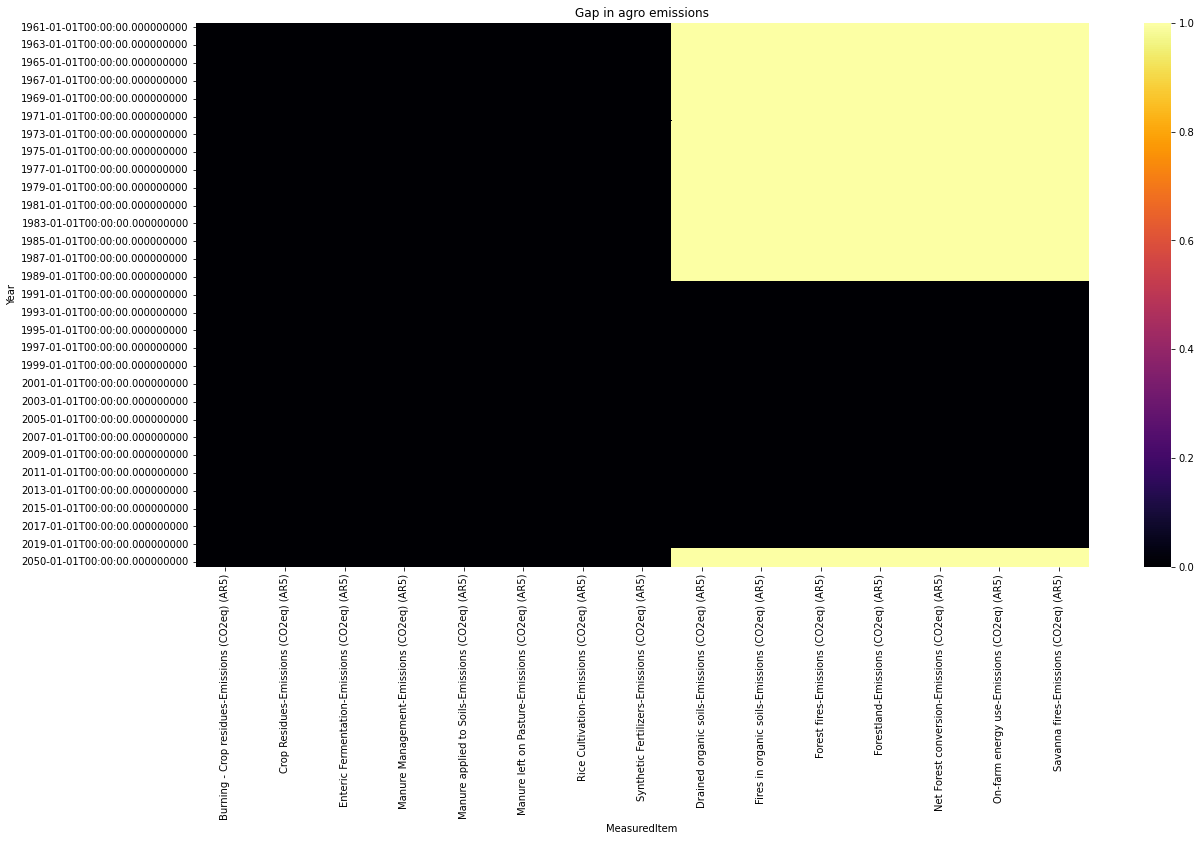

In [523]:
### mostrar donde se encuentran los gaps, tanto nulos como lineas inexistentes
show_gaps_data(df_food_balances, "Gap in food balances")
show_gaps_data(df_emissions_share, "Gap in emission shares")
show_gaps_data(df_emissions, "Gap in agro emissions")


In [524]:
DataDesc(df_food_balances)

### Vemos que tiene nulos y que hay que convertir a fecha el año

Dataset Shape: (2386512, 12)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Area Code,int64,0,178,2,2,2,7.47
1,Area,object,0,178,Afghanistan,Afghanistan,Afghanistan,7.47
2,Item Code,int64,0,123,2501,2501,2501,6.87
3,Item,object,0,120,Population,Population,Population,6.81
4,Element Code,int64,0,18,511,511,511,3.95
5,Element,object,0,18,Total Population - Both sexes,Total Population - Both sexes,Total Population - Both sexes,3.95
6,Year Code,int64,0,10,2010,2011,2012,3.32
7,Year,datetime64[ns],0,10,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00,3.32
8,Unit,object,0,5,1000 persons,1000 persons,1000 persons,1.39
9,Value,float64,56046,41320,29186.0,30117.0,31161.0,6.88


In [525]:
DataDesc(df_emissions)
### Vemos que no tiene nulos y que hay que convertir a fecha el año

Dataset Shape: (131082, 15)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Area Code,int64,0,206,2,2,2,7.60
1,Area,object,0,206,Afghanistan,Afghanistan,Afghanistan,7.60
2,Item Code,int64,0,15,5058,5058,5058,3.83
3,Item,object,0,15,Enteric Fermentation,Enteric Fermentation,Enteric Fermentation,3.83
4,Element Code,int64,0,1,723113,723113,723113,0.00
5,Element,object,0,1,Emissions (CO2eq) (AR5),Emissions (CO2eq) (AR5),Emissions (CO2eq) (AR5),0.00
6,Year Code,int64,0,61,1961,1962,1963,5.78
7,Year,datetime64[ns],0,61,1961-01-01 00:00:00,1962-01-01 00:00:00,1963-01-01 00:00:00,5.78
8,Source Code,int64,0,2,3050,3050,3050,0.50
9,Source,object,0,2,FAO TIER 1,FAO TIER 1,FAO TIER 1,0.50


In [526]:
DataDesc(df_emissions_share)

Dataset Shape: (42083, 12)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Area Code,int64,0,204,2,2,2,7.65
1,Area,object,0,204,Afghanistan,Afghanistan,Afghanistan,7.65
2,Item Code,int64,0,8,6504,6504,6504,2.94
3,Item,object,0,8,Fertilizers Manufacturing,Fertilizers Manufacturing,Fertilizers Manufacturing,2.94
4,Element Code,int64,0,1,723113,723113,723113,0.00
5,Element,object,0,1,Emissions (CO2eq) (AR5),Emissions (CO2eq) (AR5),Emissions (CO2eq) (AR5),0.00
6,Year Code,int64,0,30,1990,1991,1992,4.91
7,Year,datetime64[ns],4315,61,1971-01-01 00:00:00,1972-01-01 00:00:00,1973-01-01 00:00:00,5.73
8,Unit,object,0,1,kilotonnes,kilotonnes,kilotonnes,0.00
9,Value,float64,0,37499,40.8015,40.1179,38.8281,14.33


In [527]:

df_emissions_share["Year"] = pd.to_datetime(df_emissions_share["Year Code"], format='%Y') 



In [528]:
DataDesc(df_cluster_paises)
### Vemos que el cluster tiene 3 divisiones

Dataset Shape: (207, 7)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Cluster_0,uint8,0,2,1,0,1,0.97
1,Cluster_1,uint8,0,2,0,0,0,0.30
2,Cluster_2,uint8,0,2,0,0,0,0.41
3,Cluster_3,uint8,0,2,0,0,0,0.36
4,Cluster_4,uint8,0,2,0,1,0,0.62
5,Cluster_5,uint8,0,2,0,0,0,0.26
6,Area,object,0,207,Afghanistan,Albania,Algeria,7.69


# Transformación de la información
En esta sección:


*   Rellenamos nulos mediante una función de interpolación
*   Calculamos columnas mediante una función que nos permite seleccionar la información a mostrar



In [529]:
#@title Función de interpolación de nulos: my_interp()
def my_interp(x):
    if x.notnull().sum() > 1:
      return x.interpolate(method='nearest').ffill().bfill()
    else:
      if(x.isna().all()):
        return x.fillna(0)
      else:
        return x.ffill().bfill()

In [530]:
#@title Funcion de generación de dataset basados en datos de la FAO transpuestos: generate_columns_for_dataset()
def generate_columns_for_dataset(old_df, columns_to_transpose,columns_to_transpose_by,column_with_value,pathToGenerateConfigFile,auto_run = False):
  filtering_list = []
  df_filtered = old_df
  continue_with_old_config = "N"
  df_to_return = pd.DataFrame() 
  

  if(os.path.isfile(pathToGenerateConfigFile)):
    if(auto_run):
      continue_with_old_config = "Y"  
    else:
      continue_with_old_config = input("\r\nYa existe un archivo con este nombre y esta ruta, pulse [Y] si desea recuperarlo:\r\n "   )

  if(continue_with_old_config=="Y" ):
    with open(pathToGenerateConfigFile, "r") as read_file:
   
      df_to_return = pd.read_csv(pathToGenerateConfigFile, encoding = "ISO-8859-1")
      df_to_return["Year"] = pd.to_datetime(df_food_balances.Year, format='%Y')

  else:  
    for column_index in range(len(columns_to_transpose)): 

      current_column = columns_to_transpose[column_index]
      array_of_measured_items =  df_filtered.groupby(current_column).count().add_suffix("_count").reset_index()[current_column]
      
      output.clear()
      if(column_index != (len(columns_to_transpose)-1)):
        
        display(array_of_measured_items)
        value_to_filter = int(input("\r\nIntroduzca el índice de un [" + current_column + "] para filtrar:\r\n "   ))
        filtering_list.append(array_of_measured_items[value_to_filter])

      else:

        # this is the last type of row to transpose.
        decision = int(input(" \r\n Introduzca [1] si desea incluir todos los valores de ["+current_column + "]. \r\n Si prefiere filtrar los valores pulse [2]: \r\n" ))
        
        if(decision == 2):

          display(array_of_measured_items)
          value_to_filter = int(input("\r\nIntroduzca el índice de un [" + current_column + "] para filtrar:\r\n "   ))
          filtering_list.append(array_of_measured_items[value_to_filter])

          
      display(filtering_list)

      if(len(filtering_list)>0):

        for row_index in range(len(filtering_list)):

          row_to_filter = filtering_list[row_index]
          
          col = columns_to_transpose[row_index]
          df_filtered = df_filtered[df_filtered[col]==row_to_filter]
 
    columns_to_generate_prefix = "" 

    if(len(filtering_list)>0):
        for row_index in range(len(filtering_list)):
          row_to_filter = filtering_list[row_index]
          # we only filter if it is NOT the last column (this way we will be able to traspose it correctly)
          #><
          if(row_index < (len(columns_to_transpose)-1)):
            col = columns_to_transpose[row_index]
            df_filtered = df_filtered[df_filtered[col]==row_to_filter]
            columns_to_generate_prefix = (columns_to_generate_prefix + " " + row_to_filter).strip()

    
    last_granularity = columns_to_transpose[-1]
    columns_to_group_by = []
    columns_to_group_by.extend(columns_to_transpose_by)
    columns_to_group_by.append(last_granularity)

    gb_df= df_filtered.groupby(columns_to_group_by).sum().reset_index()
    df_to_return = df_filtered.groupby(columns_to_transpose_by).sum().reset_index()[columns_to_transpose_by]
    
    
    for last_level in gb_df[last_granularity].unique():
      
      #column_name = columns_to_generate_prefix+ " " +last_level
      column_name =last_level
      output.clear()
      display("Generating column "+ column_name)
      partial_df_to_merge = gb_df[gb_df[last_granularity]==last_level].copy()

      

      partial_df_to_merge[column_name] = partial_df_to_merge[column_with_value]

       #### INTERPOLATION FOR NULLS CALCULATION BASED ON AGRUPATIONS ALREADY DONE
      partial_df_to_merge[column_name] = partial_df_to_merge.groupby(columns_to_group_by)[column_name].apply(lambda x:my_interp(x))
      
      
      partial_df_to_merge.reset_index()



      list_column_to_use = []
      list_column_to_use.append(column_name)
      list_column_to_use.extend(columns_to_transpose_by) 
      
      partial_df_to_merge_cleaned = partial_df_to_merge[list_column_to_use].copy()
      df_to_return = pd.merge(df_to_return, partial_df_to_merge_cleaned, on = columns_to_transpose_by, how = "left")
  output.clear()
  
  if(continue_with_old_config!="Y"):
    df_to_return.to_csv(pathToGenerateConfigFile,index=False)
  
  display(df_to_return.head(3).T.head(10))    
  
  return df_to_return
    
  
  

    
        
      
    





In [531]:
#@title hyperparameters funcion generator Feature Generator
from statsmodels.tsa.seasonal import seasonal_decompose

class FeatureGenerator(object):
    
    '''
    This is a helper class that takes a df and a list of features and creates sum, mean, 
    lag features and variation (change over month) features.
    
    '''
    
    def __init__(self, full_df,  gb_list,name):
        
        '''
        Constructor of the class.
        gb_list is a list of columns that must be in full_df.
        '''
        
        self.full_df = full_df
        self.gb_list = gb_list
        self.gb = self.full_df.groupby(self.gb_list)
        
        self.objective_column_name = name
            
    def generate_gb_df(self, operation="sum",targetToSummarize="Value" ):
        
        '''
        This function thakes the full_df and creates a groupby df based on the gb_list.
        It creates 1 column: 
            1. A sum column for every date and gb_list
            
        The resulting df (gb_df_) is assigned back to the FeatureGenerator class as an attribute.
        '''

        def my_agg(full_df_, args):
            
            '''
            This function is used to perform multiple operations over a groupby df and returns a df
            without multiindex.
            '''
            
            if (operation == "sum"):
                names = {
                    # you can put here as many columns as you want . CHANGED TO BE PARAMETRIC AND ONLY ONE OPERATION PER GENERATION
                    ('{}_sum_'+targetToSummarize+"_").format(args):  full_df_[targetToSummarize].sum(),
                }
            if (operation == "mean"):
                names = {
                    # you can put here as many columns as you want . CHANGED TO BE PARAMETRIC AND ONLY ONE OPERATION PER GENERATION
                    ('{}_mean_'+targetToSummarize+"_").format(args):  full_df_[targetToSummarize].mean(),
                }
            if (operation == "max"):
                names = {
                    # you can put here as many columns as you want . CHANGED TO BE PARAMETRIC AND ONLY ONE OPERATION PER GENERATION
                    ('{}_max_'+targetToSummarize+"_").format(args):  full_df_[targetToSummarize].max(),
                }
            if (operation == "min"):
                names = {
                    # you can put here as many columns as you want . CHANGED TO BE PARAMETRIC AND ONLY ONE OPERATION PER GENERATION
                    ('{}_min_'+targetToSummarize+"_").format(args):  full_df_[targetToSummarize].min(),
                }

            return pd.Series(names, index = [key for key in names.keys()])
        
        # the args is used to pass additional argument to the apply function
        gb_df_ = self.gb.apply(my_agg, args = (self.objective_column_name)).reset_index()
        

        self.gb_df_ = gb_df_

        
    def return_gb_df(self,operation="sum",targetToSummarize="Value", p=2,q=1):  
        
        '''
        This function takes the gb_df_ created in the previous step (generate_gb_df) and creates additional features.
        We create 3 lag features (values from the past).
        And 6 variation features: 3 with absolute values and 3 with porcentual change.
        '''
        
        def generate_shift_features(self, suffix):
            
            '''
            This function is a helper function that takes the gb_df_ and a suffix (sum or mean) and creates the
            additional features.
            '''

            # dinamically creates the features
            # date_shop_id --> date_shop_id_sum if suffix is sum
            # date_shop_id --> date_shop_id_mean if suffix is mean
            name_ = self.objective_column_name + "_" + suffix + "_" +  targetToSummarize + "_"
            
            
            for lag in range(p) : 
                # lag start in 1
                lag= lag+1
                self.gb_df_[('{}_shift_'+str(lag)).format(name_)] =\
                self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(lag))

            for error in range(q) :
                error= error+1
                self.gb_df_[('{}_var_pct_'+str(error)).format(name_)] =\
                self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: (x.shift(1) - x.shift(error+1))/x.shift(error+1))

            
            
            self.gb_df_.fillna(-1, inplace = True)

            self.gb_df_.replace([np.inf, -np.inf], -1, inplace = True)
            self.gb_df_.drop(name_, axis=1, inplace=True)
        
        # call the generate_shift_featues function with different suffix (sum and mean)
        generate_shift_features(self, operation)
    
        return self.gb_df_
        

## Generación de columnas de alimentos por país
En esta sección creamos una columna por cada alimento país y año y rellenamos los nulos que puedan haber.

In [532]:
path ="/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/transposicion_food.csv"

### if you dont have the file the order of input is 
###    -   n for the question 
###    -   [6] for selection of Element -- Food supply quantity (kg/capita/yr)
###    -   [1] [ALL ITEMS] for selection of Items   
AUTORUNTHISWONDERFULLPROGRAM=True
feature_foods = generate_columns_for_dataset(df_food_balances,["Element","Item"],["Area","Year"],"Value",path,AUTORUNTHISWONDERFULLPROGRAM)


,0,1,2
Area,Afghanistan,Afghanistan,Afghanistan
Year,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00
Alcoholic Beverages,0.11,0.1,0.09
Animal fats,1.41,1.41,1.43
Apples and products,2.83,2.63,2.62
Bananas,0.73,0.92,1.53
Barley and products,1.09,1.85,1.3
Beer,0.1,0.09,0.09
"Beverages, Alcoholic",0.0,0.0,0.0
Bovine Meat,4.58,4.66,4.3


In [533]:
### antes veíamos que food balances contenía nulos 

Null_Count(df_food_balances)

,Column,Null_Count,Null_Percent
0,Value,56046,2.348448


In [534]:
### veamos cuantos nulos contiene nuestro nuevo generado dataset,estos nulos corresponden a años para los que no aparece información
Null_Count(feature_foods).head(10)

,Column,Null_Count,Null_Percent
0,"Alcohol, Non-Food",2092,98.031865
1,Palm kernels,2072,97.094658
2,"Meat, Aquatic Mammals",2054,96.251172
3,Cottonseed,2009,94.142455
4,Sugar beet,1664,77.975633
5,Sugar non-centrifugal,1626,76.194939
6,Ricebran Oil,1410,66.073102
7,Sorghum and products,1126,52.764761
8,Millet and products,1106,51.827554
9,Sugar cane,1016,47.610122


In [535]:
#### INTERPOLATION FOR NULLS CALCULATION BASED ON AGRUPATIONS ALREADY DONE
for column in feature_foods.columns[2:]:
  output.clear()
  display("Generating column "+column)
  feature_foods[column] = feature_foods.groupby("Area")[column].apply(lambda x:my_interp(x))
      

'Generating column Meat, Aquatic Mammals'

In [536]:
### veamos cuantos nulos contiene nuestro nuevo generado dataset
Null_Count(feature_foods).head(10)

,Column,Null_Count,Null_Percent


In [537]:
#for column in feature_foods.columns[2:]:
 #gb_list = ["Area", "Year"]
 #fe_generator = FeatureGenerator(full_df = feature_foods, gb_list = gb_list,name=column )
 #fe_generator.generate_gb_df(operation = "sum",targetToSummarize=column)
 #df_to_merge = fe_generator.return_gb_df(operation="sum",targetToSummarize=column)
 #feature_foods = pd.merge( feature_foods,df_to_merge, on = ['Area','Year'], how = 'left')


In [538]:
feature_foods.head()

,Area,Year,Alcoholic Beverages,Animal fats,Apples and products,Bananas,Barley and products,Beer,"Beverages, Alcoholic",Bovine Meat,...,"Molluscs, Other",Palm kernels,Pelagic Fish,Sugar beet,Sugar non-centrifugal,Sunflower seed,Yams,"Alcohol, Non-Food",Cottonseed,"Meat, Aquatic Mammals"
0,Afghanistan,2010-01-01,0.11,1.41,2.83,0.73,1.09,0.10,0.0,4.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Afghanistan,2011-01-01,0.10,1.41,2.63,0.92,1.85,0.09,0.0,4.66,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Afghanistan,2012-01-01,0.09,1.43,2.62,1.53,1.30,0.09,0.0,4.30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Afghanistan,2013-01-01,0.07,1.85,3.21,2.55,1.13,0.07,0.0,4.09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Afghanistan,2014-01-01,0.02,1.66,3.43,1.92,1.32,0.02,0.0,4.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Generación de columnas de emisiones agrícolas y forestales por país
En esta sección creamos una columna por cada alimento país y año y rellenamos los nulos que puedan haber.

In [539]:
path ="/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/transposicion_emisiones_CO2_eq.csv"

### Si no tienes el archivo el orden de imputación es: 
###    -   n for the question
###    -   [2] All items for selection of [Element]
###    -   [3] Para la selección de las emisiones (CO2eq) 

feature_emissions_CO2_eq = generate_columns_for_dataset(df_emissions,["Element"],["Area","Year"],"Value",path,AUTORUNTHISWONDERFULLPROGRAM)


,0,1,2
Area,Afghanistan,Afghanistan,Afghanistan
Year,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00
Emissions (CO2eq) (AR5),10783.733,10899.2617,11258.7528


In [540]:
path ="/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/transposicion_emisiones_CO2_eq_produccion.csv"

### Si no tienes el archivo el orden de imputación es: 
###    -   n for the question
###    -   [2] All items for selection of [Element]
###    -   [3] Para la selección de las emisiones (CO2eq) 

feature_emissions_CO2_eq_prod = generate_columns_for_dataset(df_emissions_share,["Element"],["Area","Year"],"Value",path,AUTORUNTHISWONDERFULLPROGRAM)


,0,1,2
Area,Afghanistan,Afghanistan,Afghanistan
Year,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00
Emissions (CO2eq) (AR5),43.9521,40.8015,40.1179


In [541]:
feature_emissions_CO2_eq.append(feature_emissions_CO2_eq_prod).groupby(["Area","Year"]).sum().reset_index().head()


,Area,Year,Emissions (CO2eq) (AR5)
0,Afghanistan,2010-01-01,101684.8885
1,Afghanistan,2011-01-01,75800.6085
2,Afghanistan,2012-01-01,89548.4209
3,Afghanistan,2013-01-01,80980.9832
4,Afghanistan,2014-01-01,85459.0476


In [542]:
### For emissions we need to transform the data to a per capita amd maybe more operations to be similar to the other columns dimensions
path ="/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/transposicion_poblacion.csv"

### Si no tienes el archivo el orden de imputación es: 
###    -   n for the question
###    -   [16] [Total Population] for selection of [Element]
###    -   [1] Para la selección de todos los [Item] 

feature_poblation = generate_columns_for_dataset(df_food_balances,["Element","Item"],["Area","Year"],"Value",path,AUTORUNTHISWONDERFULLPROGRAM)


,0,1,2
Area,Afghanistan,Afghanistan,Afghanistan
Year,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00
Population,29186.0,30117.0,31161.0


## Mergear toda la información

In [543]:
#@title Generación de producto cartesiano

feature_foods["Year"] = pd.to_datetime(feature_foods.Year, format='%Y-%m-%d')
feature_emissions_CO2_eq["Year"] = pd.to_datetime(feature_emissions_CO2_eq.Year, format='%Y-%m-%d')
feature_poblation["Year"] = pd.to_datetime(feature_poblation.Year, format='%Y-%m-%d')


### Before merging, in order to obtain a little bit more of data we would create a cartesian product
min_date=feature_foods["Year"].min()
display(min_date)
max_date=feature_foods["Year"].max()
display(max_date)
unique_areas = sorted(list(feature_foods["Area"].unique()))
date_range = pd.date_range(min_date, max_date, freq = "Y")
print("We have a total of {} years".format(len(date_range)))

cartesian_product = pd.MultiIndex.from_product([date_range,unique_areas], names = ["Year", "Area"])
cartesian_product


Timestamp('2010-01-01 00:00:00')

Timestamp('2019-01-01 00:00:00')

We have a total of 9 years


MultiIndex([('2010-12-31',                        'Afghanistan'),
            ('2010-12-31',                             'Africa'),
            ('2010-12-31',                            'Albania'),
            ('2010-12-31',                            'Algeria'),
            ('2010-12-31',                           'Americas'),
            ('2010-12-31',                             'Angola'),
            ('2010-12-31',                'Antigua and Barbuda'),
            ('2010-12-31',                          'Argentina'),
            ('2010-12-31',                            'Armenia'),
            ('2010-12-31',                               'Asia'),
            ...
            ('2018-12-31',                            'Vanuatu'),
            ('2018-12-31', 'Venezuela (Bolivarian Republic of)'),
            ('2018-12-31',                           'Viet Nam'),
            ('2018-12-31',                     'Western Africa'),
            ('2018-12-31',                       'Western As

In [544]:
#@title Merge cartesian product
full_df = pd.DataFrame(index = cartesian_product).reset_index()
full_df["Year"] =  pd.to_datetime(df_food_balances["Year"], format='%Y-%m-%d')

full_df = pd.merge(full_df, feature_foods, on = ['Area','Year'], how = 'left')



In [545]:
#@title INTERPOLATION FOR NULLS CALCULATION BASED ON AGRUPATIONS ALREADY DONE
### sudan y burundi son los que tienen todos los valores a nulo, de hecho lo podemos comprobar fácilmente
display(Null_Count(full_df[~full_df["Area"].isin(["Sudan","Burundi"])]))

## intrapolamos el rellenado de nulos otra vez por area

#### INTERPOLATION FOR NULLS CALCULATION BASED ON AGRUPATIONS ALREADY DONE
for column in full_df.columns[2:]:
  output.clear()
  display("Generating column "+column)
  full_df[column] = full_df.groupby("Area")[column].apply(lambda x:my_interp(x))


Null_Count(full_df)


'Generating column Meat, Aquatic Mammals'

,Column,Null_Count,Null_Percent


In [546]:
#@title Merge emissions
feature_emissions_CO2_eq = pd.merge( feature_poblation,feature_emissions_CO2_eq, on = ['Area','Year'], how = 'left')
feature_emissions_CO2_eq.T
# los huecos son por las estimaciones de 1961-1990 y de las predicciones hasta 2050 [Estos datos se eliminan a futuro]

,0,1,2,3,4,5,6,7,8,9,...,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088
Area,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,...,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe
Year,2010-01-01 00:00:00,2010-01-01 00:00:00,2010-01-01 00:00:00,2010-01-01 00:00:00,2010-01-01 00:00:00,2010-01-01 00:00:00,2010-01-01 00:00:00,2011-01-01 00:00:00,2011-01-01 00:00:00,2011-01-01 00:00:00,...,2011-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00,2012-01-01 00:00:00,2012-01-01 00:00:00,2012-01-01 00:00:00,2012-01-01 00:00:00,2012-01-01 00:00:00,2012-01-01 00:00:00,2012-01-01 00:00:00
Population,29186.0,29186.0,29186.0,29186.0,29186.0,29186.0,29186.0,30117.0,30117.0,30117.0,...,14439.0,14439.0,14645.0,14645.0,14645.0,14645.0,14645.0,14645.0,14645.0,14645.0
Emissions (CO2eq) (AR5),10783.733,12548.967,12079.9836,6616.7128,9889.5166,16988.1169,26199.2046,10899.2617,10262.6214,12077.1,...,25833.4678,98724.3286,5574.4499,5664.0875,6529.955,9691.661,9788.0674,25238.9096,25688.9642,99176.4699


In [547]:
#@title Convertimos las emisiones a per capita 
feature_emissions_CO2_eq["feature_emissions_CO2_eq"] = feature_emissions_CO2_eq["Emissions (CO2eq) (AR5)"]/feature_emissions_CO2_eq["Population"]	



In [548]:
feature_emissions_CO2_eq.head()
feature_emissions_CO2_eq=feature_emissions_CO2_eq.drop(["Population","Emissions (CO2eq) (AR5)"],axis=1)

In [549]:
feature_emissions_CO2_eq.head()

,Area,Year,feature_emissions_CO2_eq
0,Afghanistan,2010-01-01,0.369483
1,Afghanistan,2010-01-01,0.429965
2,Afghanistan,2010-01-01,0.413897
3,Afghanistan,2010-01-01,0.226708
4,Afghanistan,2010-01-01,0.338845


In [550]:
df_with_target = pd.merge(full_df, feature_emissions_CO2_eq, on = ['Area','Year'], how = 'left')

In [551]:
Null_Count(df_with_target).head(4)

,Column,Null_Count,Null_Percent
0,feature_emissions_CO2_eq,166,1.317565


In [552]:
feature_emissions_CO2_eq[feature_emissions_CO2_eq["feature_emissions_CO2_eq"].isna()>0]

,Area,Year,feature_emissions_CO2_eq
762,Azerbaijan,2010-01-01,NaN
763,Azerbaijan,2011-01-01,NaN
764,Azerbaijan,2012-01-01,NaN
765,Azerbaijan,2013-01-01,NaN
1308,Botswana,2010-01-01,NaN
1309,Botswana,2011-01-01,NaN
1310,Botswana,2012-01-01,NaN
1311,Botswana,2013-01-01,NaN
7153,Mongolia,2013-01-01,NaN
10386,Sudan,2018-01-01,NaN


In [553]:
df_with_target["feature_emissions_CO2_eq"] = df_with_target.groupby("Area")["feature_emissions_CO2_eq"].apply(lambda x:my_interp(x))
df_with_target[df_with_target["feature_emissions_CO2_eq"].isna()].T.head(2) 

""
Year
Area


In [554]:
df_area_code = df_food_balances[df_food_balances["Area Code"].isna()==False].groupby(["Area","Area Code"]).sum().reset_index()[["Area","Area Code"]]


df_with_target = pd.merge(df_area_code, df_with_target, on = ['Area'], how = 'left')
df_with_target = pd.merge(df_cluster_paises, df_with_target, on = ['Area'], how = 'left')

 


In [555]:
df_with_target.rename(columns = {"feature_emissions_CO2_eq":"Emissions CO2eq tonnes/capita"}, inplace = True)


In [556]:
cols_to_drop = [

"Area"
    
]
df_with_target.drop(cols_to_drop, inplace = True, axis = 1)


# Modelo predictivo

In [557]:
# ------------------------------------------------------
# separate the dates for train, validation and test

train_index = sorted(list(df_with_target["Year"].unique()))[:-2]

valida_index = [sorted(list(df_with_target["Year"].unique()))[-2]]

test_index = [sorted(list(df_with_target["Year"].unique()))[-1]]

In [558]:
# ------------------------------------------------------
# split the data into train, validation and test dataset
# we "simulate" the test dataset to be the Kaggle test dataset

X_train = df_with_target[df_with_target["Year"].isin(train_index)].drop(['Emissions CO2eq tonnes/capita', "Year"], axis=1)
Y_train = df_with_target[df_with_target["Year"].isin(train_index)]['Emissions CO2eq tonnes/capita']

X_valida = df_with_target[df_with_target["Year"].isin(valida_index)].drop(['Emissions CO2eq tonnes/capita', "Year"], axis=1)
Y_valida = df_with_target[df_with_target["Year"].isin(valida_index)]['Emissions CO2eq tonnes/capita']

X_test = df_with_target[df_with_target["Year"].isin(test_index)].drop(['Emissions CO2eq tonnes/capita', "Year"], axis = 1)
Y_test = df_with_target[df_with_target["Year"].isin(test_index)]['Emissions CO2eq tonnes/capita']

In [559]:
import time
from string import punctuation

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import LabelEncoder

import itertools
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages


st = time.time()

model = XGBRegressor(seed = 175)

model_name = str(model).split("(")[0]

day = str(dt.datetime.now()).split()[0].replace("-", "_")
hour = str(dt.datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, eval_metric = "rmse", 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True, 
    early_stopping_rounds = 10)

et = time.time()

print("Training took {} minutes!".format((et - st)/60))

[16:02:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.10644	validation_1-rmse:3.48059
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:4.03184	validation_1-rmse:3.45441
[2]	validation_0-rmse:3.96363	validation_1-rmse:3.42291
[3]	validation_0-rmse:3.90627	validation_1-rmse:3.39915
[4]	validation_0-rmse:3.84745	validation_1-rmse:3.31463
[5]	validation_0-rmse:3.81009	validation_1-rmse:3.30158
[6]	validation_0-rmse:3.77296	validation_1-rmse:3.28953
[7]	validation_0-rmse:3.73201	validation_1-rmse:3.22261
[8]	validation_0-rmse:3.69857	validation_1-rmse:3.21201
[9]	validation_0-rmse:3.66657	validation_1-rmse:3.16137
[10]	validation_0-rmse:3.64299	validation_1-rmse:3.14914
[11]	validation_0-rmse:3.61375	validation_1-rmse:3.07427
[12]	validation_0-rmse:3.58748	validatio

In [560]:
import pickle
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))

In [561]:
print("{}_{}.dat".format(model_name, t))

XGBRegressor_2022_03_30_16_02_43.dat


In [562]:
model = pickle.load(open("{}_{}.dat".format(model_name, t), "rb"))

[16:02:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


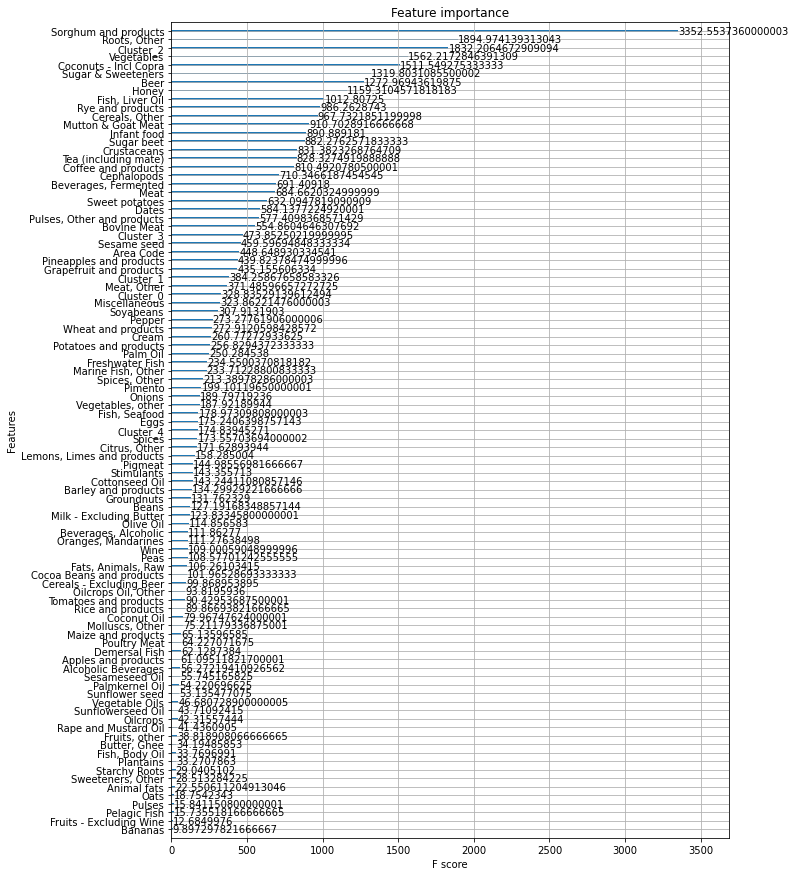

In [563]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}


fig, ax = plt.subplots(figsize = (10, 15))
plot_importance(model, importance_type = "gain", ax = ax);

In [564]:
df_impo = pd.DataFrame(importance.items(), columns=['Item', 'Importance']).reset_index()
df_impo.sort_values(by="Importance",  ascending=False).head(8)

,index,Item,Importance
94,94,Sorghum and products,3352.553736
93,93,"Roots, Other",1894.974139
92,92,Cluster_2,1832.206467
91,91,Vegetables,1562.217285
90,90,Coconuts - Incl Copra,1511.549275
89,89,Sugar & Sweeteners,1319.803109
88,88,Beer,1272.969436
87,87,Honey,1159.310457


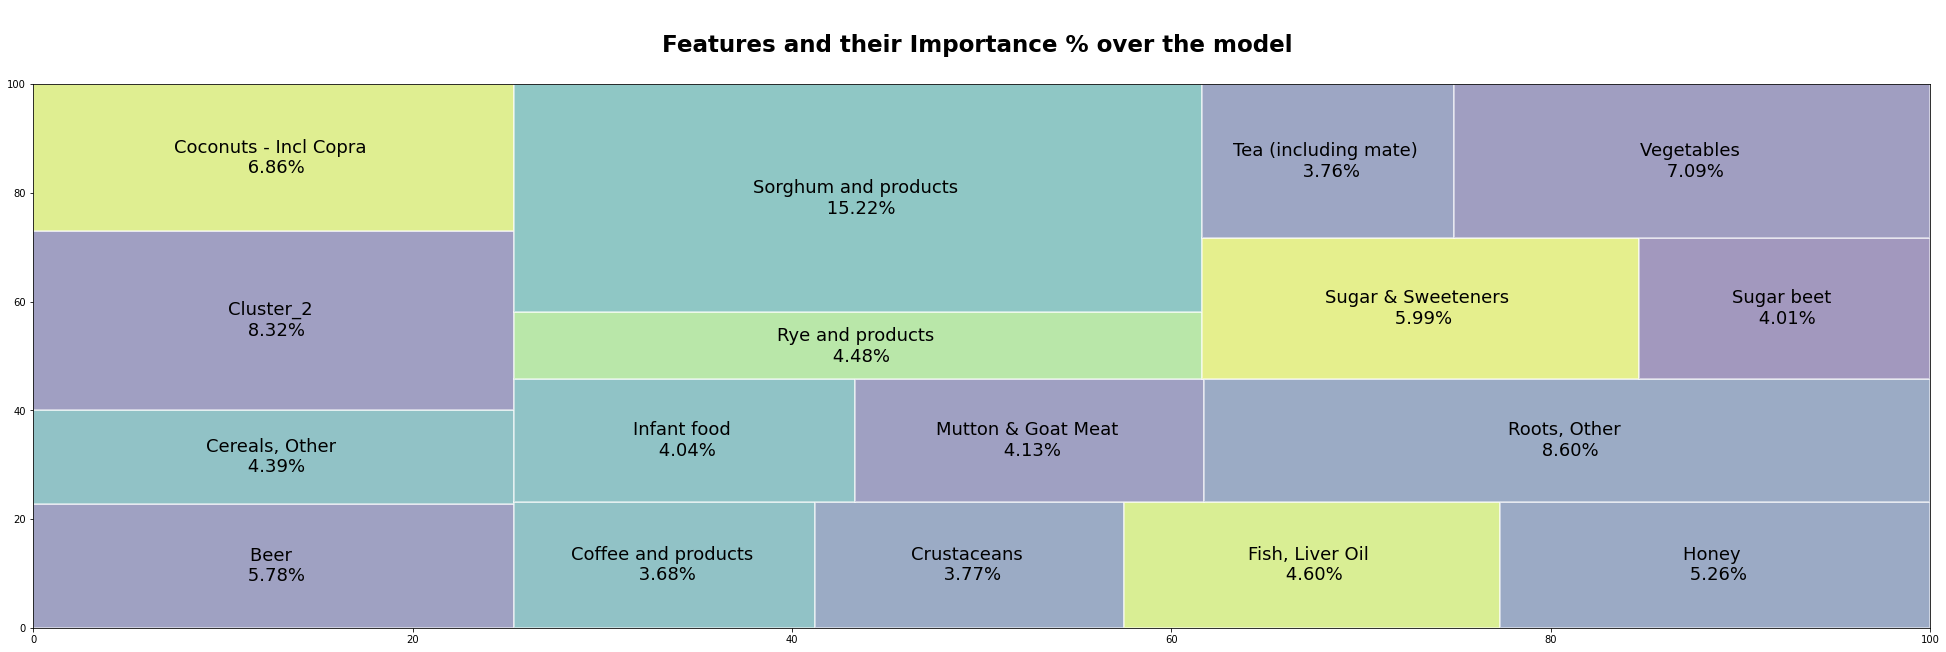

In [565]:


plot_tree_map(df_impo, "Item", "Importance","Features and their Importance % over the model", "Food supply quantity (kg/capita/yr) ")



,Metric,Result
0,RMSE,2.515923
1,R2,0.682178
2,Accuracy,57.794677


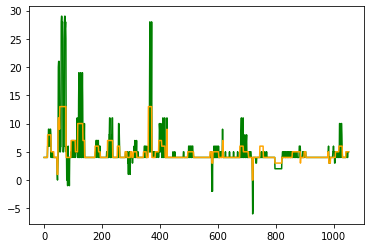

In [568]:
from sklearn import metrics
from math import sqrt
import matplotlib.pyplot as plt

Y_valida_pred = model.predict(X_valida)

r2_valida = sqrt(metrics.r2_score(Y_valida, Y_valida_pred))
rmse_valida = sqrt(metrics.mean_squared_error(Y_valida, Y_valida_pred))




# Adjustment for accuracy
index=0;
min_value = Y_valida_pred.min()
offset= 0-min_value

Y_valida_pred_off = Y_valida_pred+offset

min_value_valida = Y_valida.min()
offset_valida= 0-min_value_valida

Y_valida_off= Y_valida+offset



predictions = [round(value) for value in Y_valida_pred_off]
Y_valida_off = [round(value) for value in Y_valida_off]
# evaluate predictions
accuracy = metrics.accuracy_score(Y_valida_off, predictions)
print("\r\n")
Dict = dict({"RMSE": rmse_valida, 'R2' :r2_valida,'Accuracy' :accuracy* 100.0})
display(pd.DataFrame(Dict.items(),columns=["Metric","Result"]).set_index("Metric").reset_index())
#plot each series
print("\r\n")
plt.plot(Y_valida_off, label='Real', color='green')
plt.plot(predictions, label='Prediction', color='orange')


#display plot
plt.show()

# Información adicional : Key differences between new and old Food Balance Sheet (FBS) methodology


---



The key difference between the new and old food balances (FBS) methodologies is **the absence of a balancer variable.**

 In the past, one of the components of the FBS (often stocks, industrial
utilization or feed) would take on **the outstanding unbalanced mounts thus inheriting all the statistical errors.**

With the new methodology, the imputations for the FBS components (the data
of which are often not provided by countries) are **generated by dedicated modules; and a
balancing mechanism** will then proportionally spread the imbalances out among all the
components.

The most important output of the FBS is the Dietary Energy Supply (DES) in kilocalories per
person per day in a given country. This DES is based on the imputations generated by the
dedicated new food module. 

This module, in year t, is heavily influenced by food in year t-1,
and considering that the other variables in the module are changes in real GDP, population, and
commodity demand elasticity – all of which do not usually exhibit large variations from one
year to another - **the food quantities can be assumed to be comparable between the two methodologies.** 

However, the FBS balancing mechanism, in allocating all available quantities
to the food component for ‘food only’ commodities (e.g. meat of cattle), may result in
discrepancies with the old time series. Further analysis of this still needs to be carried out. 
